In [1]:
#import statements
import pandas as pd #data processing, CSV file I/0
import seaborn as sns #data viz
import matplotlib.pyplot as plt #data viz
import string #string class
import re # Regular Expression
from sklearn.model_selection import cross_val_score #cross validation score
from sklearn.pipeline import Pipeline #for pipeline 
import nltk #text proccessing, linguistic annotations
from sklearn.model_selection import KFold #iterable cv
from sklearn.model_selection import GridSearchCV #grid search cv
from sklearn.model_selection import train_test_split #split data
import torch #pytorch
from torch.utils.data import DataLoader #Mini batch data loader
from torch.utils.data import Dataset #Custom dataset
from torch.optim import AdamW #Optimizer for weights
import torch.nn as nn #nerual network modules
from transformers.optimization import get_linear_schedule_with_warmup #learning rate scheduler
from tqdm import tqdm #progress bar

#Import statements for Modelling
from sklearn.feature_extraction.text import CountVectorizer #CountVectorizer BOW vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #TfidfVectorizer TFIDF vectorizer
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from xgboost import XGBClassifier #xgboost
from sklearn.naive_bayes import MultinomialNB #Multinomial Naive Bayes
from transformers import AutoTokenizer #Tokenizer model agnostic
from transformers import AutoModelForSequenceClassification  # Model with head for sequence classification (agnostic)
from transformers import BertModel #Bert base model



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


### Load the datasets

In [3]:
#Load the datasets
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

#Copy raw dataframes
df_train_raw = df_train.copy(deep=True)
df_test_raw = df_train.copy(deep=True)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Check to ensure that df_test does not have target

In [4]:
print(df_train.columns)
print(df_test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [5]:
print("The shape of the df_train is: ", df_train.shape)
print("The shape of the df_test is: ", df_test.shape)

The shape of the df_train is:  (7613, 5)
The shape of the df_test is:  (3263, 4)


## 1. Exploratory Data Analysis (EDA for text datasets)

### Check the class distributions of target column

Text(0, 0.5, 'Count of Passengers')

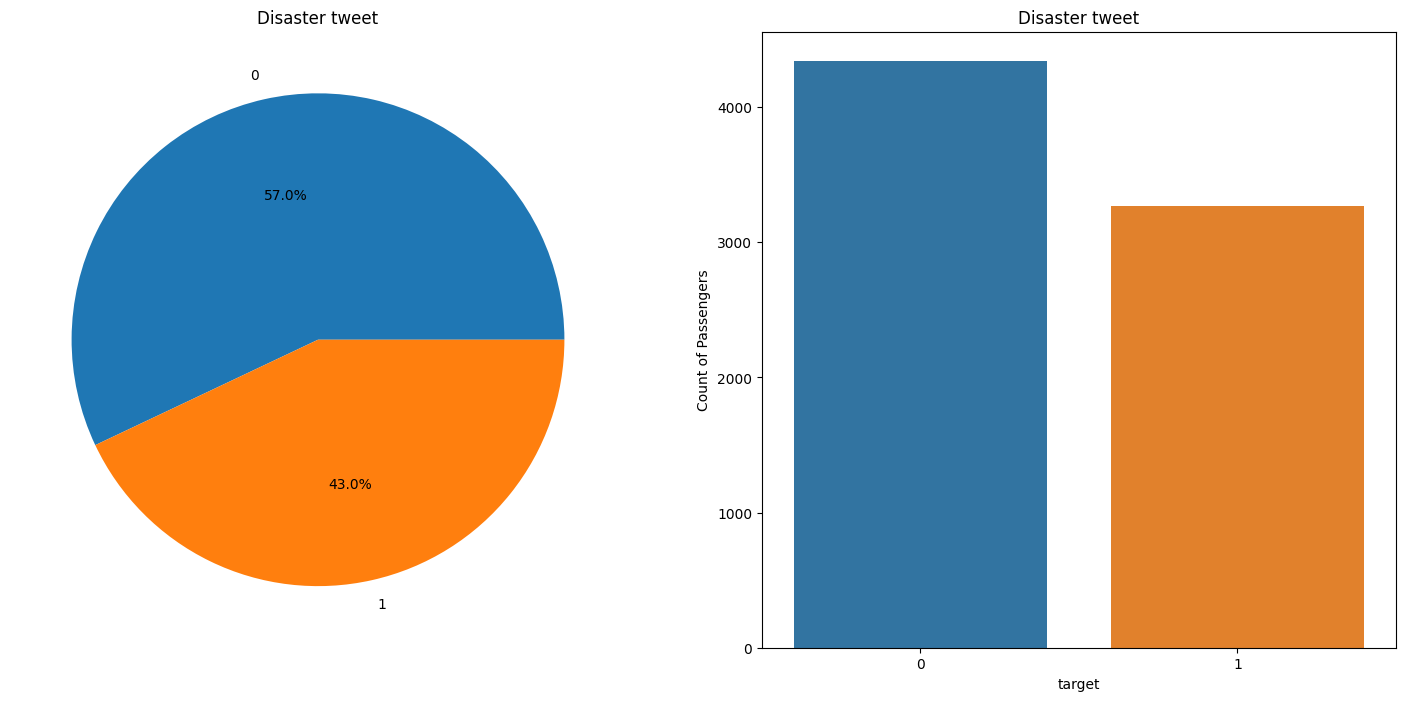

In [6]:
f,ax = plt.subplots(1,2,figsize=(18,8))
df_train["target"].value_counts().plot.pie(autopct="%1.1f%%",ax=ax[0])
ax[0].set_title("Disaster tweet")
ax[0].set_ylabel("")
sns.countplot(data=df_train,x="target",ax=ax[1])
ax[1].set_title("Disaster tweet")
ax[1].set_ylabel("Count of Passengers")

### The class distribution is not overtly skewed and as such, the scoring metric can be accuracy.

### EDA of tweets at character level, word level and sentence level to see if there were any difference in statistical distribution of text in disaster tweets and non-disaster tweets

### EDA of Meta Features  - 
1. Number of characters in text
2. Number of words in text
3. Number of unique word counts
4. Counts of punctuation
5. Counts of hashtag
6. Mentions(@) count

### Number of characters in tweets

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, '')

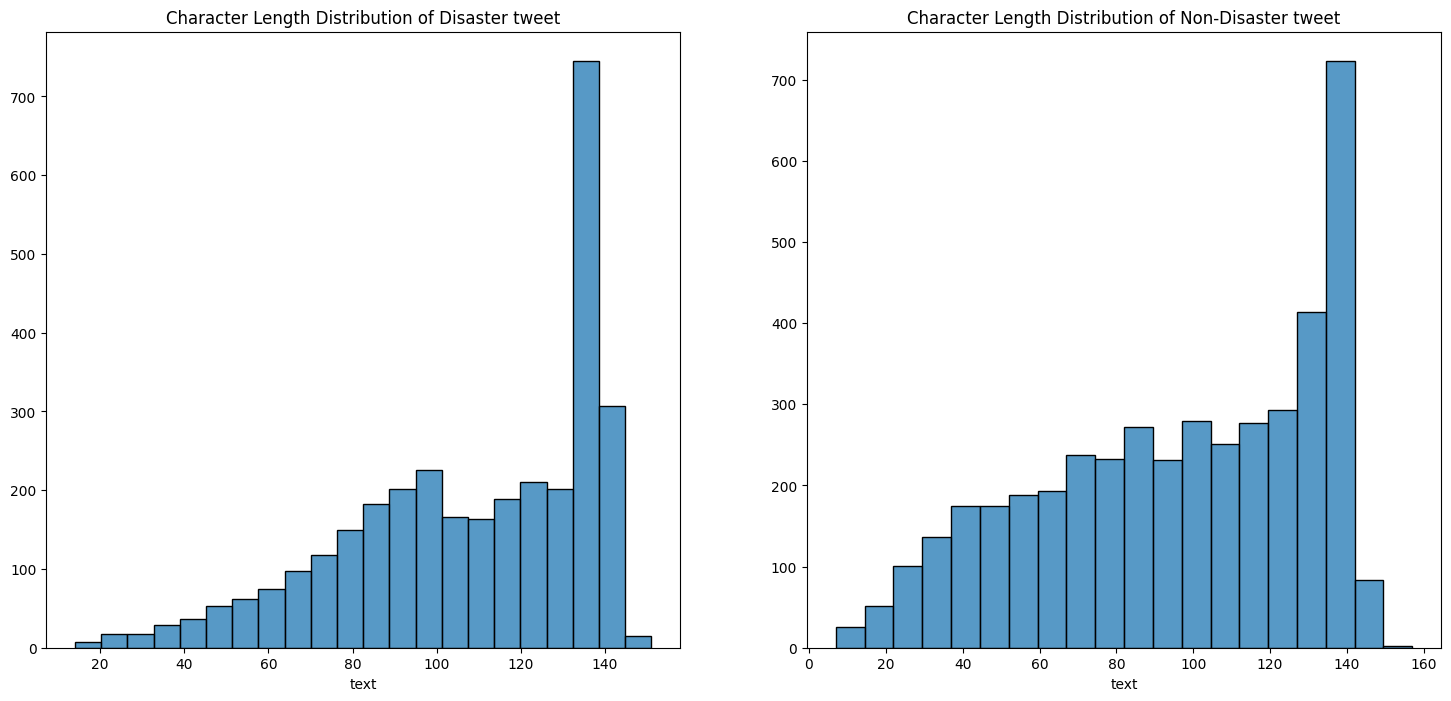

In [7]:
fig,ax = plt.subplots(1,2,figsize=(18,8))

tweet_len_dis = df_train[df_train.target == 1]["text"].str.len()
sns.histplot(data=tweet_len_dis, ax=ax[0])
ax[0].set_title("Character Length Distribution of Disaster tweet")
ax[0].set_ylabel("")

tweet_len_notdis = df_train[df_train.target == 0]["text"].str.len()
sns.histplot(data=tweet_len_notdis, ax=ax[1])
ax[1].set_title("Character Length Distribution of Non-Disaster tweet")
ax[1].set_ylabel("")

### The distribution of charcater length for both disaster tweets and non-disaster tweets are **slightly different**. The character length of non-disaster The peak of character length for both categories of tweets are around 130 -140

### Number of words in tweets

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, '')

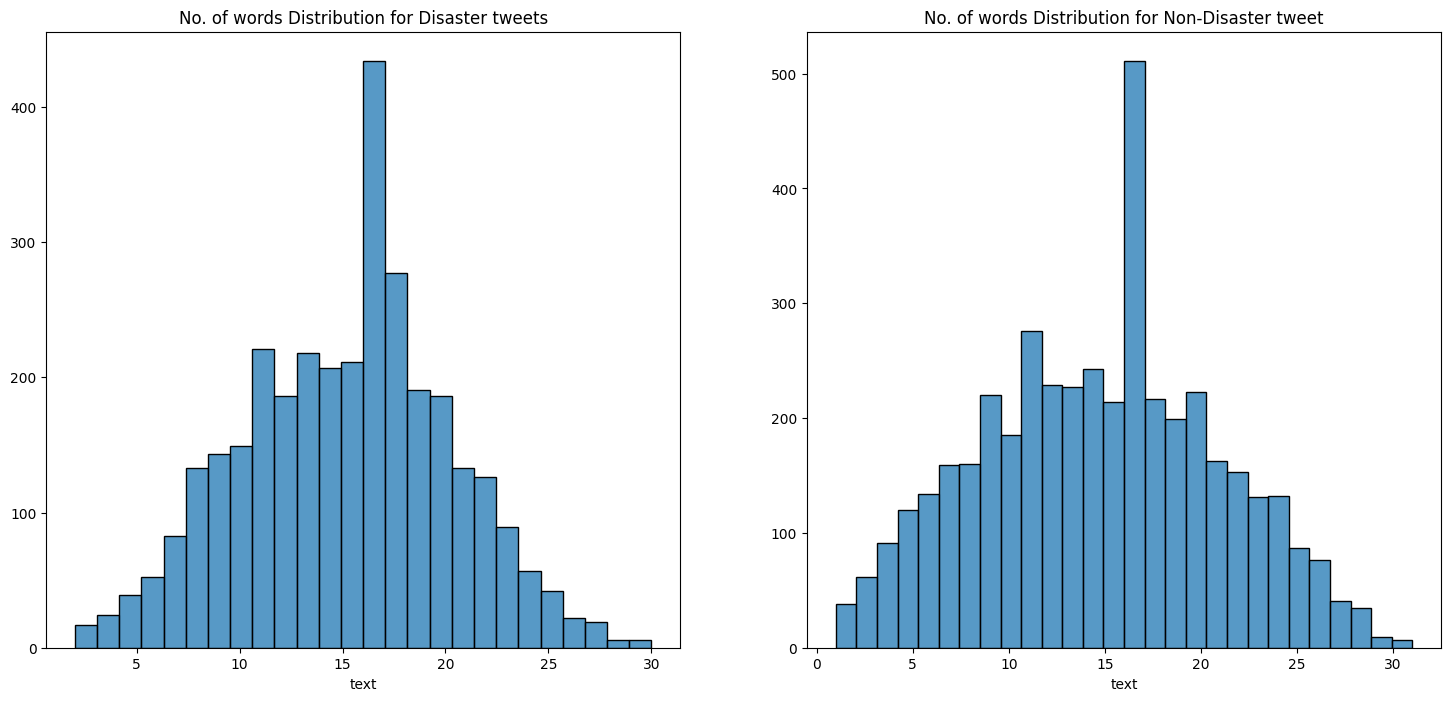

In [8]:
fig,ax = plt.subplots(1,2,figsize=(18,8))

tweet_len_dis = df_train[df_train.target == 1]["text"].apply(lambda x: len(str(x).split()))
sns.histplot(data=tweet_len_dis, ax=ax[0])
ax[0].set_title("No. of words Distribution for Disaster tweets")
ax[0].set_ylabel("")

tweet_len_notdis = df_train[df_train.target == 0]["text"].apply(lambda x: len(str(x).split()))
sns.histplot(data=tweet_len_notdis, ax=ax[1])
ax[1].set_title("No. of words Distribution for Non-Disaster tweet")
ax[1].set_ylabel("")

### The distribution of the number of words in a tweet for both disasters and non-disaster are similar.

### Unique Word Counts

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, '')

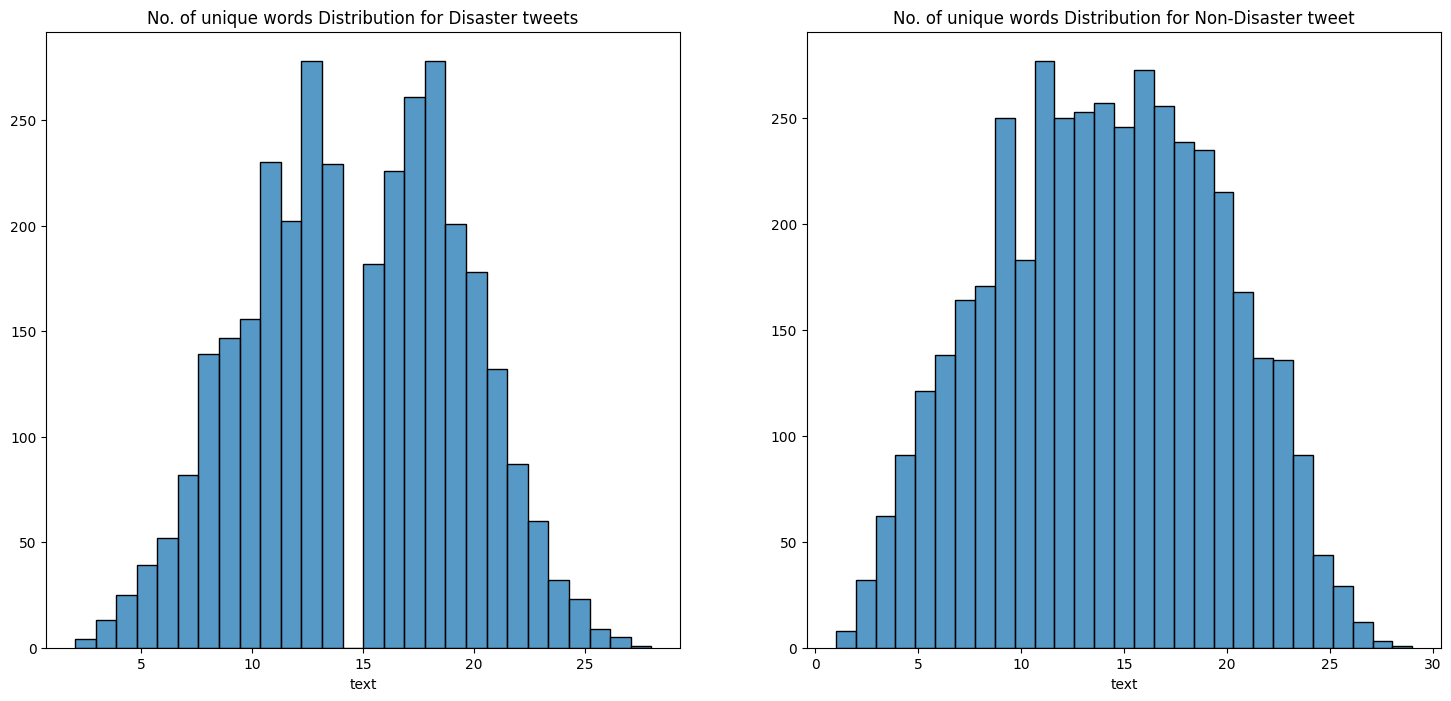

In [9]:
# unique_word_count
fig,ax = plt.subplots(1,2,figsize=(18,8))

tweet_len_dis = df_train[df_train.target == 1]["text"].apply(lambda x: len(set(str(x).split())))
sns.histplot(data=tweet_len_dis, ax=ax[0])
ax[0].set_title("No. of unique words Distribution for Disaster tweets")
ax[0].set_ylabel("")

tweet_len_notdis = df_train[df_train.target == 0]["text"].apply(lambda x: len(set(str(x).split())))
sns.histplot(data=tweet_len_notdis, ax=ax[1])
ax[1].set_title("No. of unique words Distribution for Non-Disaster tweet")
ax[1].set_ylabel("")

### The distribution for the no. of unique words in both disaster and non-disaster tweets are relatively different, especially for text length between 11 and 19 

### Punctuation Count

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, '')

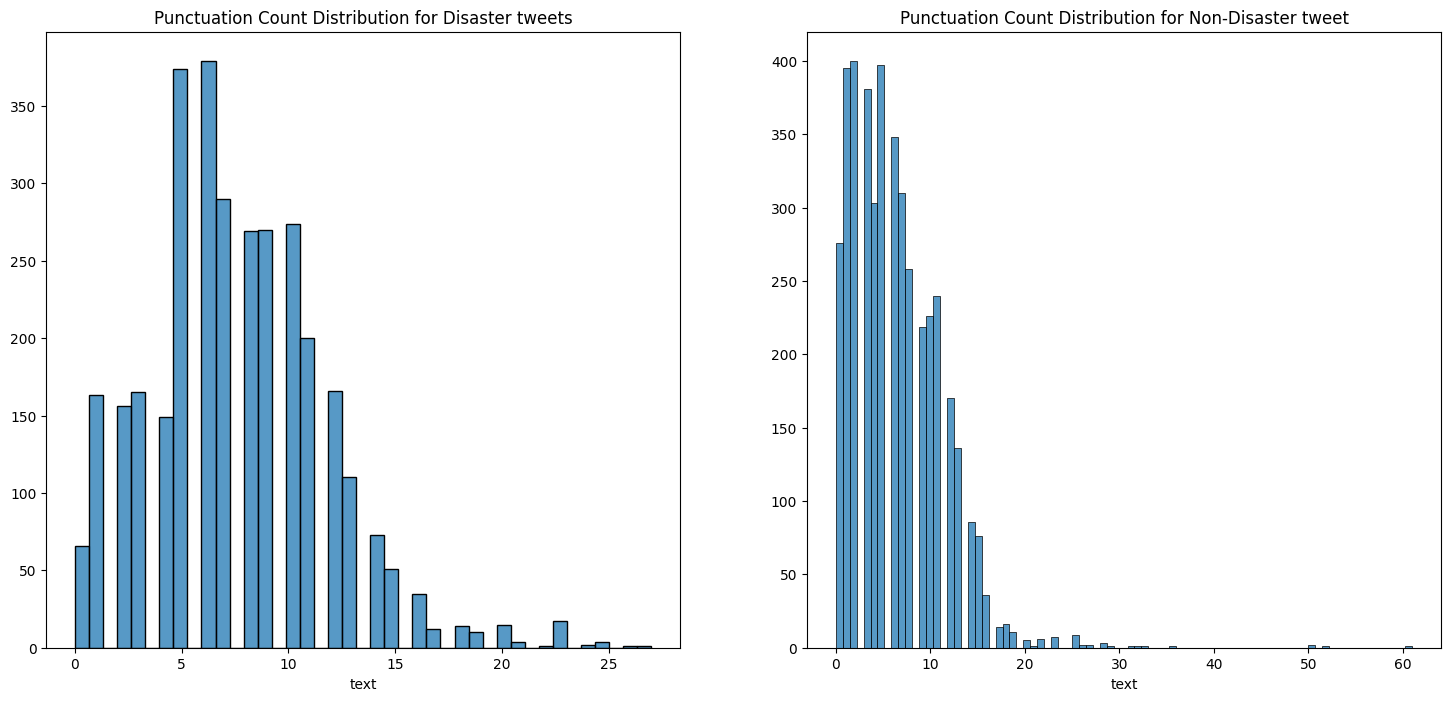

In [10]:
# Punctuation Count
fig,ax = plt.subplots(1,2,figsize=(18,8))

tweet_len_dis = df_train[df_train.target == 1]["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
sns.histplot(data=tweet_len_dis, ax=ax[0])
ax[0].set_title("Punctuation Count Distribution for Disaster tweets")
ax[0].set_ylabel("")

tweet_len_notdis = df_train[df_train.target == 0]["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
sns.histplot(data=tweet_len_notdis, ax=ax[1])
ax[1].set_title("Punctuation Count Distribution for Non-Disaster tweet")
ax[1].set_ylabel("")

### The distributions of the punctuation counts significantly differ between disaster tweets and non-disaster tweets

### Hashtag Counts (#)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, '')

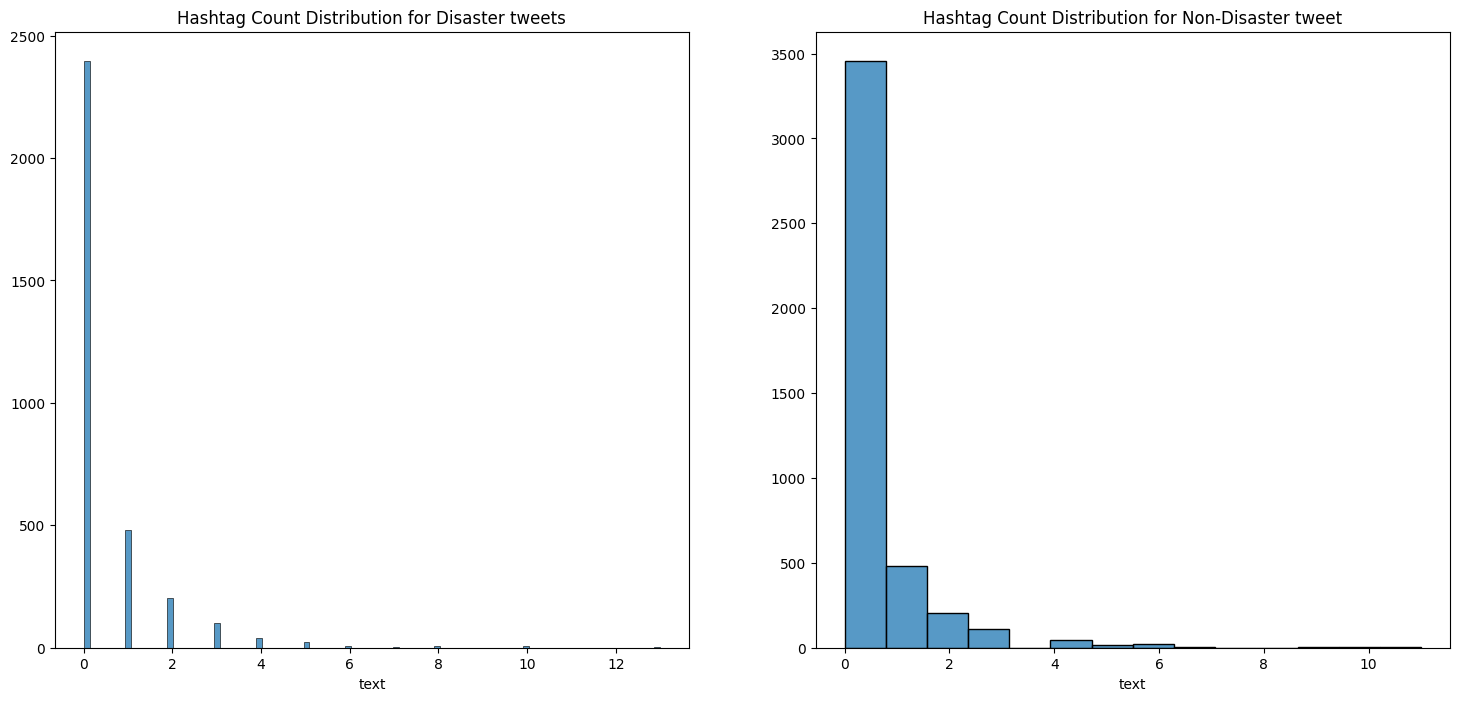

In [11]:
# Hashtag Count
fig,ax = plt.subplots(1,2,figsize=(18,8))

tweet_len_dis = df_train[df_train.target == 1]["text"].apply(lambda x: len([c for c in str(x) if c == '#']))
sns.histplot(data=tweet_len_dis, ax=ax[0])
ax[0].set_title("Hashtag Count Distribution for Disaster tweets")
ax[0].set_ylabel("")

tweet_len_notdis = df_train[df_train.target == 0]["text"].apply(lambda x: len([c for c in str(x) if c == '#']))
sns.histplot(data=tweet_len_notdis, ax=ax[1])
ax[1].set_title("Hashtag Count Distribution for Non-Disaster tweet")
ax[1].set_ylabel("")

### The distirbution for hashtag counts do not differ significantly between disaster and non-disaster tweets.

### Mention Count (@)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, '')

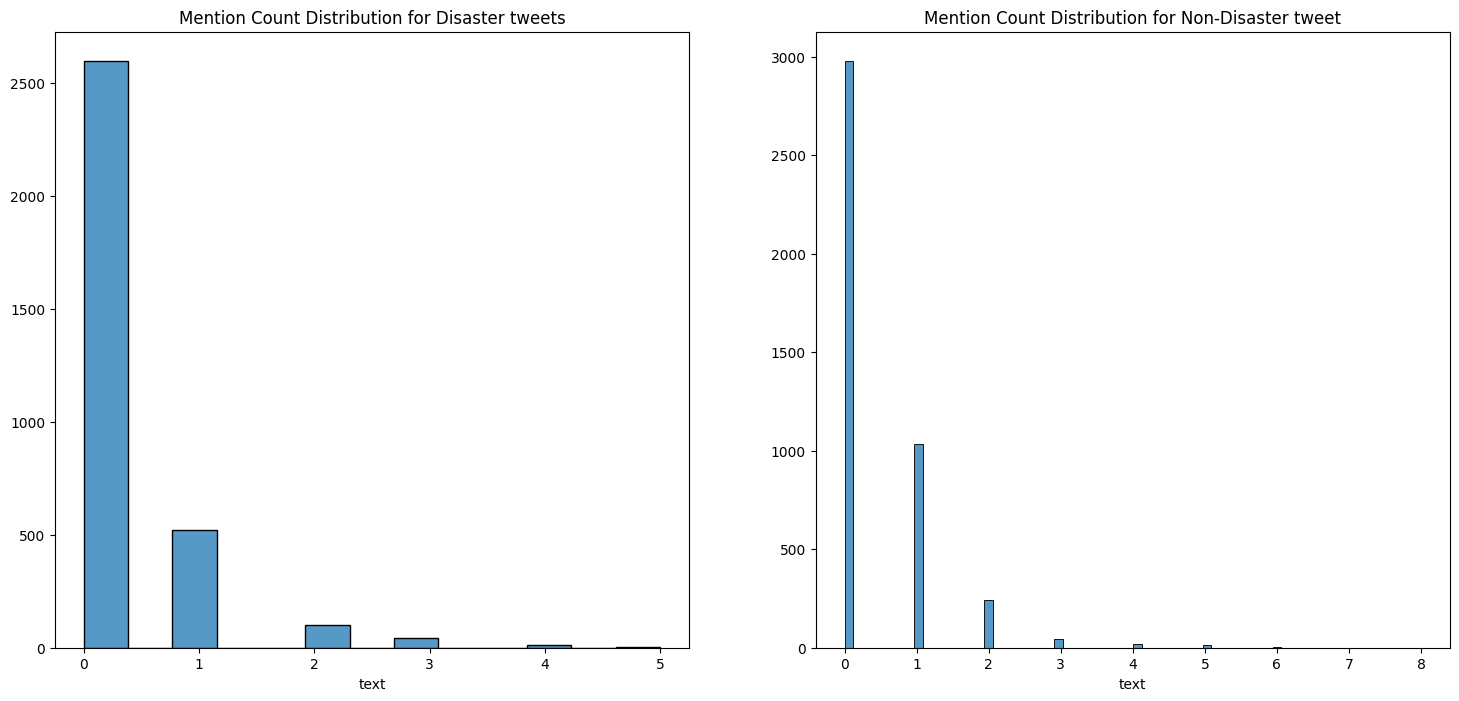

In [12]:
# Mention Count
fig,ax = plt.subplots(1,2,figsize=(18,8))

tweet_len_dis = df_train[df_train.target == 1]["text"].apply(lambda x: len([c for c in str(x) if c == '@']))
sns.histplot(data=tweet_len_dis, ax=ax[0])
ax[0].set_title("Mention Count Distribution for Disaster tweets")
ax[0].set_ylabel("")

tweet_len_notdis = df_train[df_train.target == 0]["text"].apply(lambda x: len([c for c in str(x) if c == '@']))
sns.histplot(data=tweet_len_notdis, ax=ax[1])
ax[1].set_title("Mention Count Distribution for Non-Disaster tweet")
ax[1].set_ylabel("")

### Again, the distribution for the mention counts do not significantly differ

## Data Preprocessing before baseline - Remove html tags, urls, and emojis (are not helpful in dissecting whether it is a disaster tweet or non-disaster tweet

### Remove HTML tags

In [13]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df_train['text']=df_train['text'].apply(lambda x : remove_html(x))

### Remove URLs

In [14]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df_train['text']=df_train['text'].apply(lambda x : remove_URL(x))

### Remove Emojis

In [15]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_train['text']=df_train['text'].apply(lambda x: remove_emoji(x))

## Modelling for text classification

## Classical BOW Machine Learning Models

## 1. **Baseline Model - CountVectorizer + Logistic Regression**

In [16]:
#Initialise pipeline
pipe = Pipeline([("bow_vectorizer", CountVectorizer()),("model", LogisticRegression())])
results = cross_val_score(pipe, df_train["text"], df_train["target"], cv=5)
#Results for cv and mean of results
print(results)
np.mean(results)

[0.74458306 0.65003283 0.69336835 0.69185283 0.75821288]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7076099889301408

In [17]:
#Initialize CountVectorizer
ctv = CountVectorizer()

#fit the vectorizer on corpus
ctv.fit(df_train["text"])

#Fit_transform the dataset to retrieve the document-term matrix for some intuitive understanding
corpus_transformed = ctv.transform(df_train["text"])
corpus_transformed, df_train.shape

(<Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 98800 stored elements and shape (7613, 17034)>,
 (7613, 5))

### The baseline model, Logistic Regression with CountVectorizer, has an approximate validation accuracy score of about 70%. Perform **iterative improvements** to check if the baseline models (non-deep learning and non-transformer architectures) can achieve a higher accuracy than this **baseline of 70%**.

## 2. **TFIDF Vectorizer + Logistic Regression**
### TFIDF Vectorizer transforms the count matrix to a normalised tfidf representation, thereby differentiating the common words and rarer words better

In [18]:
#Initialise pipeline using tfidfvectorizer
pipe = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),("model", LogisticRegression())])
results = cross_val_score(pipe, df_train["text"], df_train["target"], cv=5)
#Results for cv and mean of results
print(results)
np.mean(results)

[0.75049245 0.70715693 0.72554169 0.71222076 0.78120894]


0.735324153604434

### There is a marginal improvement of about 3%, highlighting that TFIDF vectorizer does well at capturing the effects of the rarer words and dampening the effects of common words (may or may not be the specific stopwords, but words that are overtly common for this corpus)

## 3. **Stemming + TFIDFVectorizer + Logistic Regression**
### Stemming is applied to the text data to reduce words to their smallest form, helping the model to undertand that different word forms have the same word meaning

In [19]:
#Initialise snowball stemmer to retrieve the stem form of the words
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

#Create a new column to prevent overwritting of old column
df_train['text_stemmed'] = df_train['text'].apply(stemm_text)
df_train.head()

,id,keyword,location,text,target,text_stemmed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed are the reason of this #earthquak may...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask to shelter in place are be notif...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 peopl receiv #wildfir evacu order in ca..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from rubi #alaska as ...


In [20]:
#Initialise pipeline
pipe = Pipeline([("tfidf_vectorizer", TfidfVectorizer()),("model", LogisticRegression())])
results = cross_val_score(pipe, df_train["text_stemmed"], df_train["target"], cv=5)
#Results for cv and mean of results
print(results)
np.mean(results)

[0.74655286 0.70387393 0.71831911 0.70367937 0.79369251]


0.733223555072765

### There is a decrease in the accuracy of the text classification task. Stemming will not be implemented in future iterations.

## 4. Cross Validation using TFIDFVectorizer + Selected Classifier Models

In [21]:
# Cross validation for various classification models 
kf = KFold(n_splits=5)
cv_mean = []
cv_std = []
cv_accuracies = []
classifier_names = ['Logistic Regression','Multinomial Naive Bayes','Decision Tree',
                    'Random Forest','XGBoost']
models=[LogisticRegression(),MultinomialNB(),DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier()]
for model in models:
    pipe = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),('model', model)])
    results = cross_val_score(pipe,df_train['text'],df_train["target"],cv=5,scoring="accuracy")
    cv_accuracies.append(results)
    cv_mean.append(np.mean(results))
    cv_std.append(np.std(results))
pd.DataFrame({'mean accuracy':cv_mean,'std accuracy':cv_std},index=classifier_names)

,mean accuracy,std accuracy
Logistic Regression,0.735324,0.027417
Multinomial Naive Bayes,0.738349,0.033424
Decision Tree,0.637462,0.030755
Random Forest,0.694870,0.044746
XGBoost,0.667283,0.039673


<Axes: >

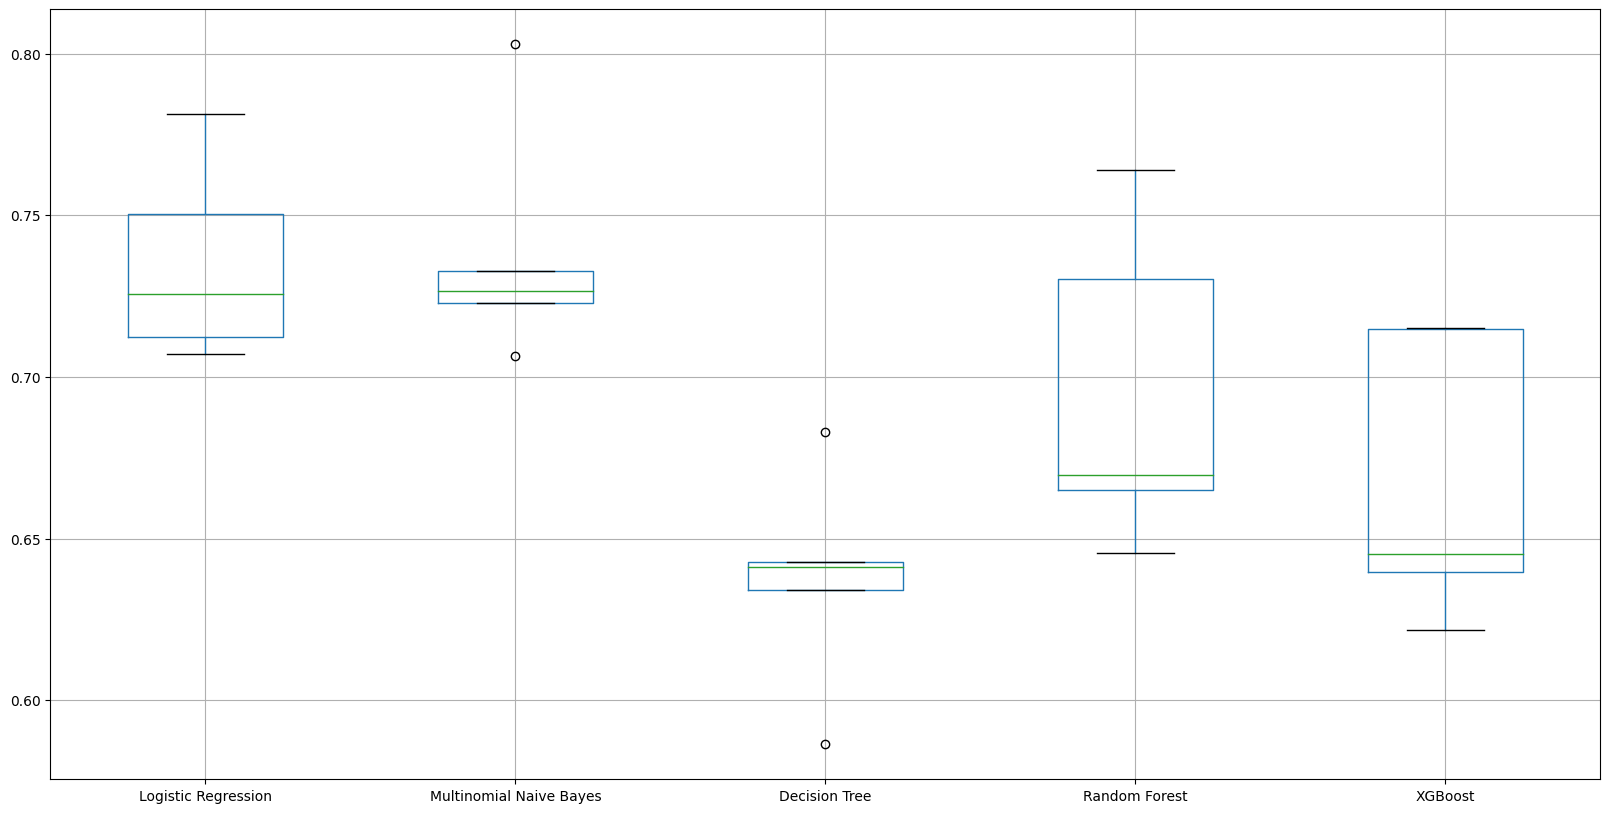

In [22]:
#Plot the cross validaiton results for visualisation, shwoing the std. deviation and mean
plt.subplots(figsize=(20,10))
accuracy_df = pd.DataFrame(cv_accuracies,index=classifier_names)
#Transpose of dataframe since boxplot is constructed from the columns axis
accuracy_df.T.boxplot()

                         mean accuracy  std accuracy
Logistic Regression           0.735324      0.027417
Multinomial Naive Bayes       0.738349      0.033424
Decision Tree                 0.637462      0.030755
Random Forest                 0.694870      0.044746
XGBoost                       0.667283      0.039673


<Axes: >

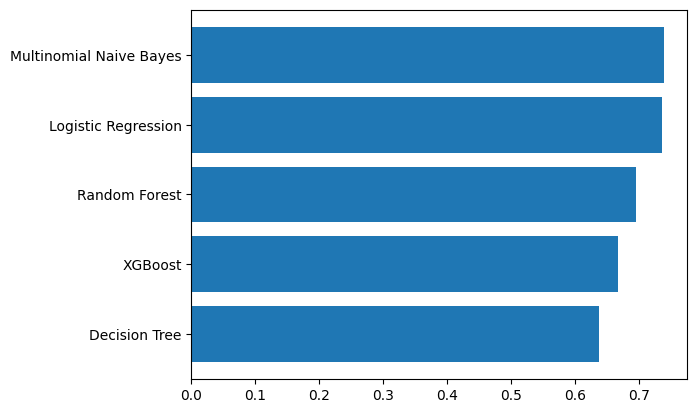

In [23]:
models_acc_df = pd.DataFrame({'mean accuracy':cv_mean,'std accuracy':cv_std},index=classifier_names)
print(models_acc_df)
models_acc_df["mean accuracy"].sort_values().plot.barh(width=0.8)

In [24]:
#Retrieve the shape of the count vectorizer, which is exactly the same for the tfidf vectorizer.
corpus_transformed.shape

(7613, 17034)

### It can be seen that non-tree based methods on average perform better than tree based models. A conjecture can be that there are many unique words which contributes to the high number of columns (not surprising for nlp problems). With many columns, tree-based models innate splitting method to implement classification task is not ideal.

## 5. **Hyperparameter Tuning (Select the top 2 models for hyperparameter tuning) + (Tune the TFIDF Vectorizer)**

### **Tune TfIdfVectorizer + Logistic Regression**

In [25]:
#Initialise classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("model", LogisticRegression())
])

#Create search params for grid search cv
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

#Fit the grid search to obtain the best score
grid = GridSearchCV(pipeline, parameters, cv=5)
grid.fit(df_train['text'], df_train["target"])

print("Best parameters set and score:")
print(grid.best_score_)
print(grid.best_params_)
print(grid.cv_results_)

Best parameters set and score:
0.7409716799697671
{'tfidf__ngram_range': (1, 2)}
{'mean_fit_time': array([1.5430645 , 2.54085698, 3.54842553]), 'std_fit_time': array([0.97576715, 0.81446059, 0.84020646]), 'mean_score_time': array([0.07385168, 0.12397976, 0.15440402]), 'std_score_time': array([0.01420218, 0.02145419, 0.00487139]), 'param_tfidf__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3)],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'tfidf__ngram_range': (1, 1)}, {'tfidf__ngram_range': (1, 2)}, {'tfidf__ngram_range': (1, 3)}], 'split0_test_score': array([0.75049245, 0.75640184, 0.75377544]), 'split1_test_score': array([0.70715693, 0.71634931, 0.71831911]), 'split2_test_score': array([0.72554169, 0.73276428, 0.7229153 ]), 'split3_test_score': array([0.71222076, 0.717477  , 0.72141919]), 'split4_test_score': array([0.78120894, 0.78186597, 0.77858081]), 'mean_test_score': array([0.73532415, 0.74097168, 0.73900197]), 'st

### **Tune TfIdfVectorizer + MultiNomial Naive Bayes**

In [26]:
#Initialise classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("model", MultinomialNB())
])

#Create search params for grid search cv
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

#Fit the grid search to obtain the best score
grid = GridSearchCV(pipeline, parameters, cv=5)
grid.fit(df_train['text'], df_train["target"])

print("Best parameters set and score:")
print(grid.best_score_)
print(grid.best_params_)
print(grid.cv_results_)

Best parameters set and score:
0.7383492536257455
{'tfidf__ngram_range': (1, 1)}
{'mean_fit_time': array([0.17932682, 0.37412419, 0.61169014]), 'std_fit_time': array([0.01678316, 0.00835123, 0.00978265]), 'mean_score_time': array([0.03271651, 0.0535378 , 0.07151041]), 'std_score_time': array([0.00222803, 0.00139619, 0.00151636]), 'param_tfidf__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3)],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'tfidf__ngram_range': (1, 1)}, {'tfidf__ngram_range': (1, 2)}, {'tfidf__ngram_range': (1, 3)}], 'split0_test_score': array([0.7229153 , 0.7216021 , 0.71634931]), 'split1_test_score': array([0.70650033, 0.70715693, 0.70124754]), 'split2_test_score': array([0.73276428, 0.72685489, 0.71897571]), 'split3_test_score': array([0.72667543, 0.72733246, 0.72141919]), 'split4_test_score': array([0.80289093, 0.80091984, 0.79632063]), 'mean_test_score': array([0.73834925, 0.73677324, 0.73086247]), 'st

### Between both tuned logistic regression and multinomial naive bayes, **tuned logistic regression** scored slightly better as coompared multinomial naive bayes.

## 6. Bert Model (Transformer - ModelForSequenceClassification)

### Bert is used as the transformer model since it is a text classification task, specifically predicting whether the tweet is about disaster. As such, Bert being an encoder model is suitable for such a text classification task

### **Importantly, raw texts are ideally fed to Bert Model since it is uncommon to utilise text processing, such as stopwords removal, lowercasing, and removal of punctuation for SOTA transformer architectures and tokenizers.**

### **Finetuning Bert Recommendations**
1. batch sizes: 8, **16**, 32, 64, 128 
2. learning rates: 3e-4, 1e-4, **5e-5**, 3e-5
3. epochs: 2,3,4 **(3 is chosen due to computational costs)**


In [27]:
#Copy raw dataframes
df_train_raw = df_train.copy(deep=True)
df_test_raw = df_train.copy(deep=True)

#Retrieve the typical x_train (labels) and y_train (labels)
df_train_labels = df_train_raw["target"].values
df_train_raw = df_train_raw["text"].values
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_train_raw,
                                                                                    df_train_labels,
                                                                                    test_size=0.2)

In [28]:
#Create Bert Tokenizer (tokenizer model agnostic)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(list(train_inputs), truncation=True, padding=True)
valid_encodings = tokenizer(list(validation_inputs), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

### Create custom dataset class and dataloaders for batch loading

In [30]:
class TweetDataset(Dataset):
    """ Custom dataset class for the encoded tweets"""
    def __init__(self,encodings,labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self,idx):
        """Need to overide this method as mentioned in docs."""
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        """Need to overide this method as mentioned in docs."""
        number_rows = len(self.labels)
        return number_rows

In [31]:
# Create a pytorch custom dataset using encodings and labels for batch loading using dataloader subsequently
train_dataset = TweetDataset(train_encodings, train_labels)
valid_dataset = TweetDataset(valid_encodings, validation_labels)

#Dataloaders for batch loading instead of loading full dataset (memory issues)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [32]:
# Create model with head for text classification (model agnostic)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [33]:
#Set up device agnostic code - either GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
#Adam with Weight Decay (to prevent overfitting)
optimizer = AdamW(model.parameters(),
              lr=5e-5,
              weight_decay=0.01)

In [35]:
#Learning rate scheduler with warmup steps to allow for gradual learning, instead of a sudden change in direction
NUM_EPOCHS = 3
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * NUM_EPOCHS)

In [36]:
#define accuracy function for reusability
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [37]:
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}")
    
    #Training
    train_loss, train_acc = 0, 0
    #Add a loop to loop through the training batches
    for batch_idx, batch in enumerate(train_loader):        
        ### Prepare data and use GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        #Allow configs for learning (e.g. weight updates)
        model.train()

        #Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        #Returns (max,max_indices)
        _, y_pred_labels = torch.max(logits,1)
        
        #Calculate the training loss per batch
        train_loss += loss
        #Calculate the training accuracy per batch
        train_acc += accuracy_fn(y_true=labels,
                                 y_pred=y_pred_labels)
        
        #Optimizer zero grad
        optimizer.zero_grad()
        
        #Loss backward
        loss.backward()
        
        #Optimizer step
        optimizer.step()
        
        #Scheduler step (lr step) is after changing the weights
        scheduler.step()
        
    #Average train loss per batch in an epoch and Average train accuracy per batch in an epoch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    #Append values for plotting
    train_loss_list.append(train_loss.cpu().detach().numpy())
    #train_loss_list.append(train_loss.item())
    train_accuracy_list.append(train_acc)
        
    #Testing
    test_loss, test_acc = 0, 0
    #Set to eval mode to prevent auto diff.
    model.eval()
    with torch.inference_mode():
        for batch_idx, batch in enumerate(valid_loader):
            ### Prepare data and use GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            #Forward Pass (BatchEncoding data type, docs)
            outputs = model(input_ids,attention_mask=attention_mask,labels=labels)
            loss, logits = outputs['loss'], outputs['logits']
            #Returns (max,max_indices)
            _, y_pred_labels = torch.max(logits,1)
            
            test_loss += loss
            #Calculate the validation accuracy per batch
            test_acc += accuracy_fn(y_true=labels,
                                    y_pred=y_pred_labels)
            
        #Average test loss per batch in an epoch and Average test accuracy per batch in an epoch
        test_loss /= len(valid_loader)
        test_acc /= len(valid_loader)
        #Append values for plotting
        val_loss_list.append(test_loss.cpu().detach().numpy())
        #val_loss_list.append(test_loss.item())
        val_accuracy_list.append(test_acc)
        
    print(f"\n Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"\n Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0


 33%|███▎      | 1/3 [01:27<02:55, 87.99s/it]


 Train Loss: 0.4850 | Test Loss: 0.3996

 Train Acc: 77.4245 | Test Acc: 83.2031
Epoch: 1


 67%|██████▋   | 2/3 [02:59<01:30, 90.05s/it]


 Train Loss: 0.3514 | Test Loss: 0.4210

 Train Acc: 86.1614 | Test Acc: 83.2031
Epoch: 2


100%|██████████| 3/3 [04:31<00:00, 90.34s/it]


 Train Loss: 0.1990 | Test Loss: 0.4560

 Train Acc: 92.7657 | Test Acc: 82.2917


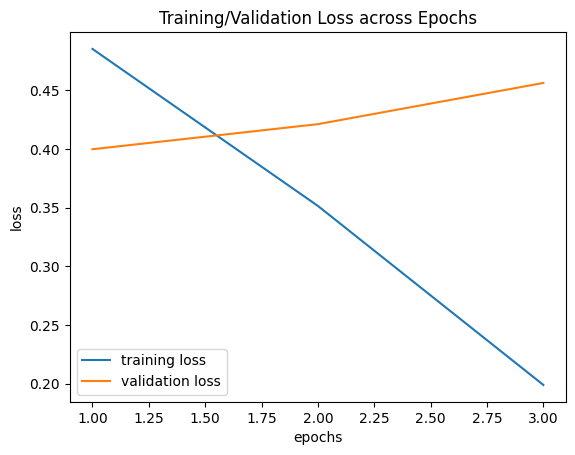

In [38]:
#Plot the loss curves for training loss and validation loss
num_epochs = len(train_loss_list)
plt.plot(np.arange(1,num_epochs+1),train_loss_list,label="training loss")
plt.plot(np.arange(1,num_epochs+1),val_loss_list,label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation Loss across Epochs")
plt.legend()
plt.show()

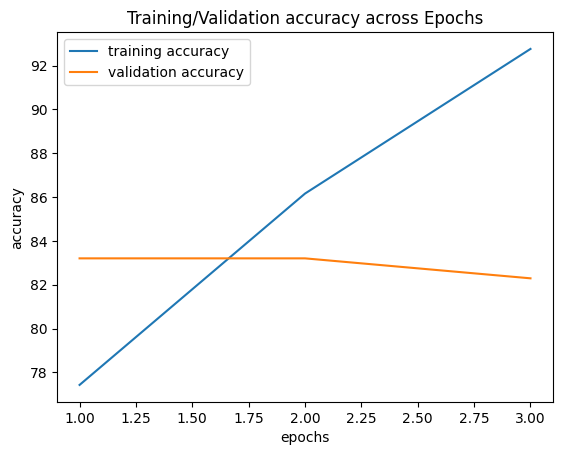

In [39]:
#Plot the accuracy curves for training accuracy and validation accuracy
num_epochs = len(train_loss_list)
plt.plot(np.arange(1,num_epochs+1),train_accuracy_list,label="training accuracy")
plt.plot(np.arange(1,num_epochs+1),val_accuracy_list,label="validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy across Epochs")
plt.legend()
plt.show()

### There is some overfitting of the model possibly due to the small dataset size as neural networks, especailly neweer transformer architectures modes like Bert overfit easily on a small dataset size.

## 7. Bert Model (Changes in the head architecture using BertModel as a base to address overfitting)

In [64]:
bert_model = BertModel.from_pretrained("bert-base-uncased",return_dict=False)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [65]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### As expected, the bert model is the base model architecture without the classification head. We can include additional layers, particularly dropout layers with higher probability to address finetuning. However, these dropout layer should not be placed just before the last layer, which would lead to poor results.

In [66]:
class DisasterTweetsModel(nn.Module):
    """ A simple bert model for training a binary classification problem"""
    def __init__(self):
        super(DisasterTweetsModel,self).__init__()
        #Bert base foundaitonal model
        self.bert = bert_model
        #Classifier Head
        self.classifier = nn.Sequential(
            nn.Dropout(0.35),
            nn.Linear(768,768),
            nn.Linear(768,512),
            nn.Linear(512,256),
            nn.Linear(256,2)
        )
        
    def forward(self,input_ids,attention_mask,labels=None):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        logits = self.classifier(pooled_output)
        #Train,Valid will have labels
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))
            return loss,logits
        #Pred/Inference will not have labels
        else:
            return logits
            

In [67]:
# Create model with head for text classification (model agnostic)
model_1 = DisasterTweetsModel() 
model_1.to(device) 

DisasterTweetsModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [68]:
#Adam with Weight Decay (to prevent overfitting)
optimizer = AdamW(model_1.parameters(),
              lr=2e-5,
              weight_decay=0.01)

In [69]:
#Learning rate scheduler with warmup steps to allow for gradual learning, instead of a sudden change in direction
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * NUM_EPOCHS)

In [70]:
NUM_EPOCHS = 3
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}")
    
    #Training
    train_loss, train_acc = 0, 0
    #Add a loop to loop through the training batches
    for batch_idx, batch in enumerate(train_loader):        
        ### Prepare data and use GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        #Allow configs for learning (e.g. weight updates)
        model_1.train()

        #Forward pass
        outputs = model_1(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs
        #Returns (max,max_indices)
        _, y_pred_labels = torch.max(logits,1)
        
        #Calculate the training loss per batch
        train_loss += loss
        #Calculate the training accuracy per batch
        train_acc += accuracy_fn(y_true=labels,
                                 y_pred=y_pred_labels)
        
        #Optimizer zero grad
        optimizer.zero_grad()
        
        #Loss backward
        loss.backward()
        
        #Optimizer step
        optimizer.step()
        
        #Scheduler step (lr step) is after changing the weights
        scheduler.step()
        
    #Average train loss per batch in an epoch and Average train accuracy per batch in an epoch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    #Append values for plotting
    train_loss_list.append(train_loss.cpu().detach().numpy())
    #train_loss_list.append(train_loss.item())
    train_accuracy_list.append(train_acc)
        
    #Testing
    test_loss, test_acc = 0, 0
    #Set to eval mode to prevent auto diff.
    model_1.eval()
    with torch.inference_mode():
        for batch_idx, batch in enumerate(valid_loader):
            ### Prepare data and use GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            #Forward Pass (BatchEncoding data type, docs)
            outputs = model_1(input_ids,attention_mask=attention_mask,labels=labels)
            loss, logits = outputs
            #Returns (max,max_indices)
            _, y_pred_labels = torch.max(logits,1)
            
            test_loss += loss
            #Calculate the validation accuracy per batch
            test_acc += accuracy_fn(y_true=labels,
                                    y_pred=y_pred_labels)
            
        #Average test loss per batch in an epoch and Average test accuracy per batch in an epoch
        test_loss /= len(valid_loader)
        test_acc /= len(valid_loader)
        #Append values for plotting
        val_loss_list.append(test_loss.cpu().detach().numpy())
        #val_loss_list.append(test_loss.item())
        val_accuracy_list.append(test_acc)
        
    print(f"\n Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"\n Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0


 33%|███▎      | 1/3 [01:32<03:04, 92.00s/it]


 Train Loss: 0.5237 | Test Loss: 0.4232

 Train Acc: 73.3629 | Test Acc: 81.5755
Epoch: 1


 67%|██████▋   | 2/3 [03:03<01:31, 91.93s/it]


 Train Loss: 0.3750 | Test Loss: 0.4083

 Train Acc: 84.9967 | Test Acc: 83.0729
Epoch: 2


100%|██████████| 3/3 [04:35<00:00, 91.95s/it]


 Train Loss: 0.2574 | Test Loss: 0.4756

 Train Acc: 90.7218 | Test Acc: 82.2917


### Without plotting the graphs, it is clearly evident that there is still overfitting even after changing the classifier layers of the bert model for sequence classification. From both of the model architecture, it seems that the **second epoch** has the highest validation accuracy. 

### One possible reason is that the dataset is small and fine-tuning BERT models require fewer number of epochs, which is exactly the reason that the BERT authors recommended 2-4 epochs for fine-tuning

### Proceed to fit on the whole training data and use BERT model for prediction on the test set, since BERT provides the highest validation accuracy compared to classical BOW models.